#  Entraînement d'un modèle de reconnaissance visuelle de la parole simple
 
 Ce notebook guide à travers les étapes d'entraînement d'un modèle VSR (Visual Speech Recognition) simple capable de reconnaître 4 mots français : "oui", "non", "un" et "deux" uniquement à partir des mouvements des lèvres.
 
##  Processus d'entraînement
 
 1. **Chargement des données** : Les images des lèvres collectées pour chaque mot sont chargées depuis les dossiers correspondants.
 
 2. **Prétraitement des images** : Chaque image est redimensionnée à une taille fixe, convertie en niveaux de gris et normalisée pour standardiser l'entrée du modèle.
 
 3. **Organisation en séquences** : Les images sont regroupées en séquences temporelles correspondant à chaque prononciation d'un mot.
 
 4. **Division des données** : Les exemples sont divisés en ensembles d'entraînement (80%) et de test (20%) pour évaluer la capacité de généralisation du modèle.
 
 5. **Entraînement du modèle** : Un réseau de neurones à convolution (CNN) combiné à un réseau récurrent (LSTM) est entraîné pour classifier les mouvements des lèvres.
 
 6. **Évaluation** : Le modèle est évalué sur l'ensemble de test pour mesurer sa précision.
 
 7. **Test en temps réel** : Une fonction permet de tester le modèle avec de nouveaux enregistrements vidéo.

##  Choix du modèle et architecture
 
 Pour ce projet, nous utilisons une architecture CNN+LSTM spécialement adaptée à la VSR. Voici pourquoi ce choix est approprié :
 
  Pourquoi une architecture CNN+LSTM ?
 
 1. **Extraction des caractéristiques spatiales** : Les réseaux CNN sont excellents pour extraire des caractéristiques visuelles pertinentes à partir d'images. Ils peuvent identifier les formes et mouvements des lèvres.
 
 2. **Modélisation des séquences temporelles** : Les LSTM (Long Short-Term Memory) sont conçus pour capturer les dépendances temporelles dans des séquences, ce qui est crucial pour comprendre les mouvements des lèvres qui se déroulent dans le temps.
 
 3. **Robustesse aux variations** : Cette architecture hybride peut s'adapter à différents locuteurs et conditions d'enregistrement.
 
##  Architecture du modèle
 
 Notre modèle utilise la configuration suivante :
 
 - **Entrée** : Séquence d'images de lèvres (30 frames de taille 64x64x1 pour 1 seconde à 30 FPS)
 - **Couches CNN** : Extraction de caractéristiques spatiales avec 3 blocs convolutifs
 - **TimeDistributed** : Application du CNN à chaque frame de la séquence
 - **LSTM** : Modélisation des dépendances temporelles avec 2 couches bidirectionnelles
 - **Dense** : Couches entièrement connectées pour la classification
 - **Sortie** : 4 neurones (un pour chaque mot) avec fonction softmax
 
##  Hyperparamètres
 
 - **Taux d'apprentissage** : 0.001 avec décroissance
 - **Taille du batch** : 16 (adapté à la quantité de données disponible)
 - **Nombre d'époques** : 100 avec early stopping
 - **Optimiseur** : Adam (efficace pour les réseaux profonds)
 - **Fonction de perte** : Entropie croisée catégorielle

#  Importation des bibliothèques


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, TimeDistributed
from tensorflow.keras.layers import LSTM, Bidirectional, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tqdm.notebook import tqdm
import random

# Configuration de matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

print("Bibliothèques importées avec succès !")



Bibliothèques importées avec succès !


## Configuration des paramètres

In [2]:
# Paramètres globaux
img_size = 64                # Taille des images redimensionnées
max_sequence_length = 30     # Nombre maximum d'images par séquence (1 seconde * 30 fps)
validation_split = 0.2       # Pourcentage de données pour la validation
random_seed = 42             # Pour la reproductibilité

# Chemins des dossiers
lip_frames_dir = "../data/lip_frames"
processed_dir = "../data/processed"
models_dir = "../models"

# Créer les dossiers s'ils n'existent pas
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# Mots cibles
target_words = ["oui", "non", "un", "deux"]

print(f"Configuration terminée ! Nous allons traiter les mots suivants : {target_words}")

Configuration terminée ! Nous allons traiter les mots suivants : ['oui', 'non', 'un', 'deux']


## Chargement et préparation des données

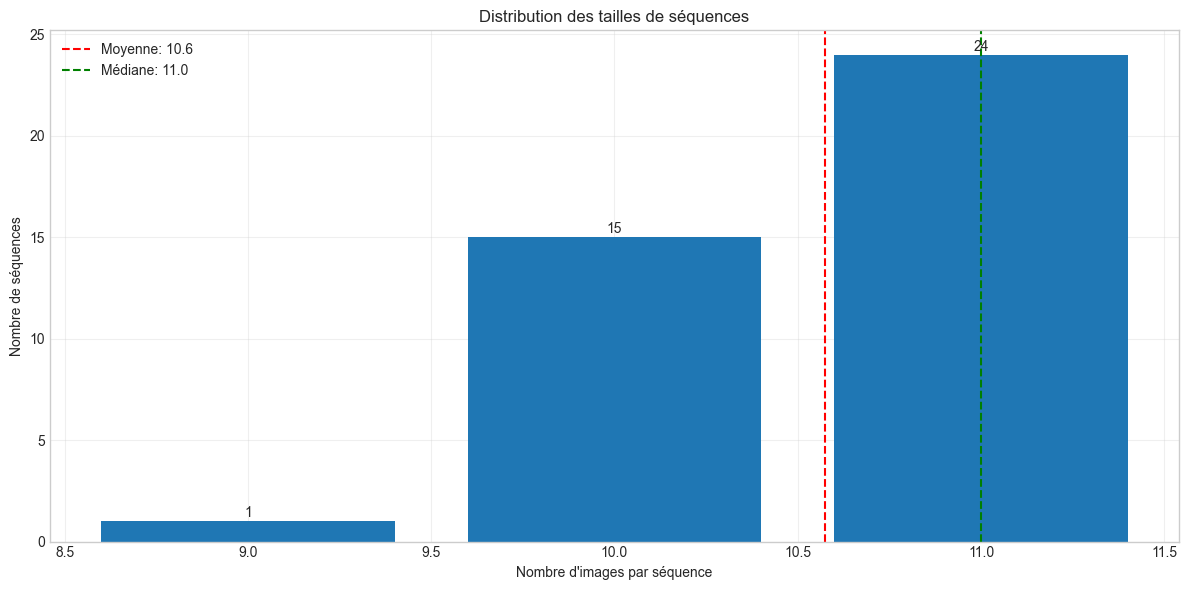

In [3]:
def visualize_sequence_lengths():
    # Collecter toutes les séquences sans normalisation
    sequences = []
    
    for word in target_words:
        word_dir = os.path.join(lip_frames_dir, word)
        
        if not os.path.isdir(word_dir):
            continue
        
        # Identifier les séquences uniques par leur préfixe
        sequence_prefixes = set()
        for file in os.listdir(word_dir):
            if file.endswith('.png'):
                parts = file.split('_')
                if len(parts) >= 2:
                    prefix = f"{parts[0]}_{parts[1]}"
                    sequence_prefixes.add(prefix)
        
        for prefix in sequence_prefixes:
            # Compter le nombre d'images dans cette séquence
            sequence_files = [f for f in os.listdir(word_dir) if f.startswith(prefix) and f.endswith('.png')]
            sequences.append(len(sequence_files))
    
    # Visualiser la distribution des tailles
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    plt.hist(sequences, bins=range(min(sequences), max(sequences) + 2), align='left', rwidth=0.8)
    plt.xlabel('Nombre d\'images par séquence')
    plt.ylabel('Nombre de séquences')
    plt.title('Distribution des tailles de séquences')
    plt.grid(True, alpha=0.3)
    
    # Ajouter des informations statistiques
    plt.axvline(x=np.mean(sequences), color='red', linestyle='--', label=f'Moyenne: {np.mean(sequences):.1f}')
    plt.axvline(x=np.median(sequences), color='green', linestyle='--', label=f'Médiane: {np.median(sequences)}')
    
    # Ajouter le nombre exact pour chaque taille
    for i in range(min(sequences), max(sequences) + 1):
        count = sequences.count(i)
        if count > 0:
            plt.text(i, count + 0.2, str(count), ha='center')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

visualize_sequence_lengths()

On sait donc qu'on pas ajouter un padidng jusqu'à 11.

In [4]:
def load_and_preprocess_sequence(sequence_dir, target_length=11):
    """
    Charge et prétraite une séquence d'images de lèvres.
    
    Args:
        sequence_dir: Chemin vers le dossier contenant les images d'une séquence
        target_length: Nombre exact d'images souhaitées pour chaque séquence (11 d'après le graphique)
    
    Returns:
        np.array: Séquence prétraitée de forme (target_length, img_size, img_size, 1)
    """
    # Obtenir toutes les images de la séquence
    image_files = sorted(glob(os.path.join(sequence_dir, "*.png")))
    
    # Charger et prétraiter chaque image
    processed_images = []
    
    for img_file in image_files:
        # Charger l'image
        img = cv2.imread(img_file)
        
        # Convertir en niveaux de gris
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Redimensionner
        resized = cv2.resize(gray, (img_size, img_size))
        
        # Normaliser les valeurs entre 0 et 1
        normalized = resized / 255.0
        
        # Ajouter à la liste
        processed_images.append(normalized)
    
    # Compléter jusqu'à avoir exactement 11 images si nécessaire
    current_length = len(processed_images)
    if current_length < target_length:
        # Dupliquer la dernière image pour atteindre target_length (11)
        last_image = processed_images[-1] if processed_images else np.zeros((img_size, img_size))
        for _ in range(target_length - current_length):
            processed_images.append(last_image.copy())
    
    # Convertir en tableau numpy et ajouter la dimension des canaux
    sequence = np.array(processed_images[:target_length]).reshape(target_length, img_size, img_size, 1)
    
    return sequence

In [5]:
def load_data():
    """
    Charge toutes les séquences d'images et prépare les données d'entraînement.
    
    Returns:
        tuple: (X, y) avec X les séquences d'images et y les étiquettes
    """
    sequences = []
    labels = []
    
    print("Chargement et prétraitement des données...")
    
    for word_idx, word in enumerate(target_words):
        word_dir = os.path.join(lip_frames_dir, word)
        
        if not os.path.isdir(word_dir):
            print(f"ATTENTION: Le dossier {word_dir} n'existe pas !")
            continue
        
        # Identifier les séquences uniques par leur préfixe
        sequence_prefixes = set()
        for file in os.listdir(word_dir):
            if file.endswith('.png'):
                # Format attendu: mot_XX_YYY.png où XX est l'indice de séquence
                parts = file.split('_')
                if len(parts) >= 2:
                    prefix = f"{parts[0]}_{parts[1]}"
                    sequence_prefixes.add(prefix)
        
        print(f"Traitement de {len(sequence_prefixes)} séquences pour le mot '{word}'...")
        
        for prefix in tqdm(sequence_prefixes):
            # Obtenir tous les fichiers pour cette séquence
            sequence_files = [f for f in os.listdir(word_dir) if f.startswith(prefix) and f.endswith('.png')]
            
            if len(sequence_files) >= 5:  # Seulement les séquences avec au moins 5 images
                # Créer un dossier temporaire pour cette séquence
                temp_dir = os.path.join(processed_dir, "temp_sequence")
                os.makedirs(temp_dir, exist_ok=True)
                
                # Copier les fichiers dans le dossier temporaire
                for file in sequence_files:
                    src_path = os.path.join(word_dir, file)
                    dst_path = os.path.join(temp_dir, file)
                    # Utiliser un lien symbolique ou une copie
                    try:
                        os.symlink(src_path, dst_path)
                    except:
                        # Si les liens symboliques ne sont pas supportés, copier
                        import shutil
                        shutil.copy2(src_path, dst_path)
                
                # Charger et prétraiter la séquence
                sequence = load_and_preprocess_sequence(temp_dir)
                
                # Nettoyer le dossier temporaire
                for file in os.listdir(temp_dir):
                    os.remove(os.path.join(temp_dir, file))
                os.rmdir(temp_dir)
                
                if sequence is not None:
                    sequences.append(sequence)
                    labels.append(word_idx)
    
    # Convertir en tableaux numpy
    X = np.array(sequences)
    y = np.array(labels)
    
    # Encoder les étiquettes
    y_encoded = to_categorical(y, num_classes=len(target_words))
    
    return X, y_encoded

In [6]:
# Charger les données
X, y = load_data()

print(f"Données chargées : {X.shape[0]} séquences, {X.shape[1]} frames par séquence")
print(f"Forme des données : {X.shape}")


Chargement et prétraitement des données...
Traitement de 10 séquences pour le mot 'oui'...


  0%|          | 0/10 [00:00<?, ?it/s]

Traitement de 10 séquences pour le mot 'non'...


  0%|          | 0/10 [00:00<?, ?it/s]

Traitement de 10 séquences pour le mot 'un'...


  0%|          | 0/10 [00:00<?, ?it/s]

Traitement de 10 séquences pour le mot 'deux'...


  0%|          | 0/10 [00:00<?, ?it/s]

Données chargées : 40 séquences, 11 frames par séquence
Forme des données : (40, 11, 64, 64, 1)


## Division des données en ensembles d'entraînement et de test

In [7]:
# Diviser en ensembles d'entraînement et de test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=validation_split, random_state=random_seed, stratify=y.argmax(axis=1)
)

print(f"Ensemble d'entraînement : {X_train.shape[0]} exemples")
print(f"Ensemble de test : {X_test.shape[0]} exemples")

# Vérifier la distribution des classes
train_distribution = {
    target_words[i]: np.sum(y_train.argmax(axis=1) == i) 
    for i in range(len(target_words))
}
test_distribution = {
    target_words[i]: np.sum(y_test.argmax(axis=1) == i) 
    for i in range(len(target_words))
}

print("\nDistribution des classes :")
print(f"Entraînement : {train_distribution}")
print(f"Test : {test_distribution}")

Ensemble d'entraînement : 32 exemples
Ensemble de test : 8 exemples

Distribution des classes :
Entraînement : {'oui': 8, 'non': 8, 'un': 8, 'deux': 8}
Test : {'oui': 2, 'non': 2, 'un': 2, 'deux': 2}


# Augmentation du jeu de données

In [8]:
def visualize_augmentations(X_data, y_data):
    """
    Affiche des exemples d'augmentation pour chaque classe de mot.
    
    Args:
        X_data: Données originales (séquences d'images)
        y_data: Étiquettes correspondantes (one-hot encodées)
    """
    import matplotlib.pyplot as plt
    
    # Convertir les étiquettes one-hot en indices de classe
    y_indices = np.argmax(y_data, axis=1)
    
    # Sélectionner un exemple de chaque classe
    examples = []
    for class_idx, word in enumerate(target_words):
        # Trouver toutes les séquences de cette classe
        class_indices = np.where(y_indices == class_idx)[0]
        if len(class_indices) > 0:
            # Prendre le premier exemple
            example_idx = class_indices[0]
            examples.append((example_idx, word, X_data[example_idx]))
    
    # Créer une figure avec 4 colonnes (original + 3 augmentations) et une ligne par classe
    fig, axes = plt.subplots(len(examples), 4, figsize=(15, 3*len(examples)))
    
    # Pour chaque classe
    for i, (example_idx, word, sequence) in enumerate(examples):
        # Afficher quelques frames de la séquence originale choisir une frame du milieu de la séquence pour visualisation
        mid_frame_idx = sequence.shape[0] // 2
        
        # Séquence originale
        ax = axes[i, 0]
        ax.imshow(sequence[mid_frame_idx, :, :, 0], cmap='gray')
        if i == 0:
            ax.set_title("Original")
        ax.set_ylabel(f"'{word}'")
        ax.axis('off')
        
        # Créer et afficher différentes augmentations
        
        # 1. Rotation
        frame = sequence[mid_frame_idx, :, :, 0].copy()
        angle = 15  # Rotation fixe pour la visualisation
        M = cv2.getRotationMatrix2D((img_size//2, img_size//2), angle, 1)
        rotated = cv2.warpAffine(frame, M, (img_size, img_size))
        
        ax = axes[i, 1]
        ax.imshow(rotated, cmap='gray')
        if i == 0:
            ax.set_title("Rotation")
        ax.axis('off')
        
        # 2. Luminosité
        frame = sequence[mid_frame_idx, :, :, 0].copy()
        brightness = 1.2  # Augmentation de luminosité pour la visualisation
        brightened = np.clip(frame * brightness, 0, 1)
        
        ax = axes[i, 2]
        ax.imshow(brightened, cmap='gray')
        if i == 0:
            ax.set_title("Luminosité")
        ax.axis('off')
        
        # 3. Zoom
        frame = sequence[mid_frame_idx, :, :, 0].copy()
        zoom = 0.9  # Zoom out pour la visualisation
        h, w = frame.shape
        zh = int(h * zoom)
        zw = int(w * zoom)
        
        top = (h - zh) // 2
        left = (w - zw) // 2
        
        zoomed = np.zeros((img_size, img_size))
        zoomed[top:top+zh, left:left+zw] = cv2.resize(frame, (zw, zh))
        
        ax = axes[i, 3]
        ax.imshow(zoomed, cmap='gray')
        if i == 0:
            ax.set_title("Zoom")
        ax.axis('off')
        
            
    plt.tight_layout()
    plt.suptitle("Visualisation des techniques d'augmentation de données", y=1.02, fontsize=16)
    plt.show()
    
    # Visualiser une séquence complète augmentée
    if len(examples) > 0:
        # Prendre la première séquence comme exemple
        sequence = examples[0][2]
        
        # Créer une séquence augmentée complète
        aug_sequence = np.zeros_like(sequence)
        
        for f in range(sequence.shape[0]):
            frame = sequence[f, :, :, 0]
            
            # Appliquer toutes les augmentations
            angle = np.random.uniform(-15, 15)
            M = cv2.getRotationMatrix2D((img_size//2, img_size//2), angle, 1)
            rotated = cv2.warpAffine(frame, M, (img_size, img_size))
            
            brightness = np.random.uniform(0.8, 1.2)
            brightened = np.clip(rotated * brightness, 0, 1)
                        # Sauvegarder la frame augmentée
            aug_sequence[f, :, :, 0] = brightened
        
        # Afficher la séquence originale vs la séquence augmentée
        fig, axes = plt.subplots(2, min(sequence.shape[0], 8), figsize=(16, 5))
        
        # Limiter à 8 frames maximum pour la visualisation
        num_frames = min(sequence.shape[0], 8)
        
        for f in range(num_frames):
            # Séquence originale
            axes[0, f].imshow(sequence[f, :, :, 0], cmap='gray')
            axes[0, f].set_title(f"Frame {f+1}")
            axes[0, f].axis('off')
            
            # Séquence augmentée
            axes[1, f].imshow(aug_sequence[f, :, :, 0], cmap='gray')
            axes[1, f].axis('off')
        
        axes[0, 0].set_ylabel("Original")
        axes[1, 0].set_ylabel("Augmenté")
        
        plt.tight_layout()
        plt.suptitle("Comparaison d'une séquence originale et augmentée", y=0.98, fontsize=16)
        plt.show()

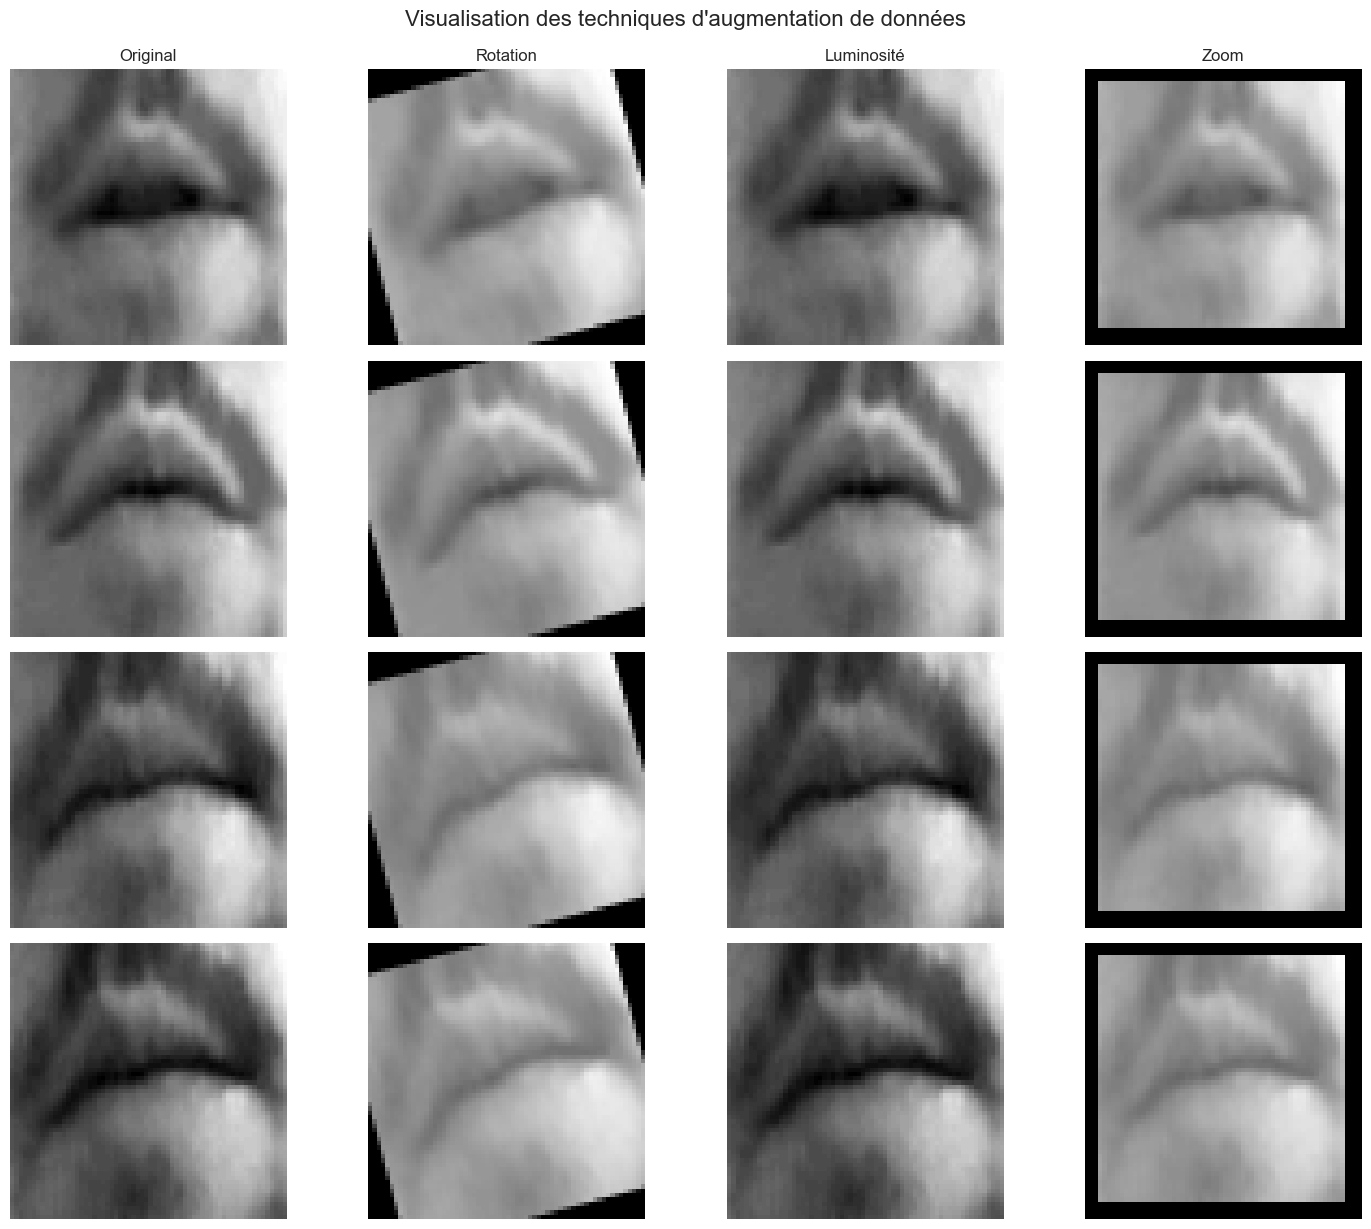

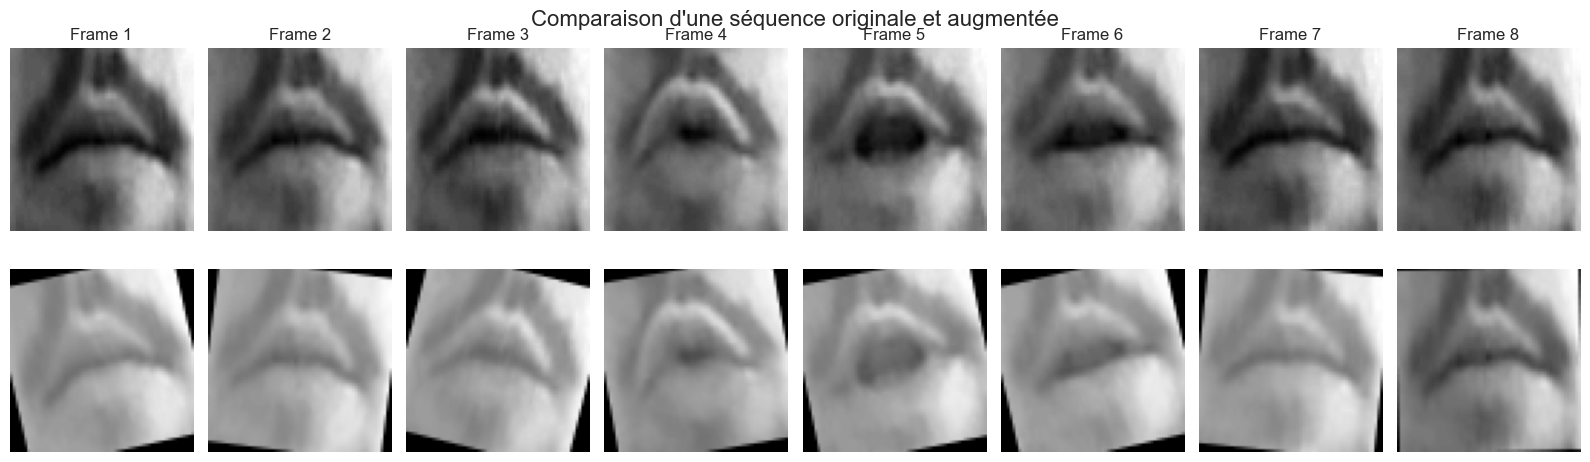

In [9]:
# Pour utiliser la fonction:
visualize_augmentations(X_train, y_train)

In [10]:
# Ajout d'une fonction d'augmentation de données intensive
def apply_augmentation(X_data):
    """
    Applique une augmentation de données intensive aux séquences d'images.
    
    Args:
        X_data: Données originales de forme [samples, frames, height, width, channels]
    
    Returns:
        X_augmented: Données augmentées
    """
    print("Application de l'augmentation de données...")
    X_augmented = []
    y_augmented = []
    
    # Pour chaque séquence dans les données
    for i in range(len(X_data)):
        sequence = X_data[i]
        original_label = y_train[i]
        
        # Ajouter la séquence originale
        X_augmented.append(sequence)
        y_augmented.append(original_label)
        
        # Créer 5 versions augmentées (multiplier dataset par 6)
        for j in range(5):
            aug_sequence = np.zeros_like(sequence)
            
            # Appliquer différentes augmentations à chaque frame
            for f in range(sequence.shape[0]):
                frame = sequence[f, :, :, 0]
                
                # Rotation aléatoire légère (-15 à +15 degrés)
                angle = np.random.uniform(-15, 15)
                M = cv2.getRotationMatrix2D((img_size//2, img_size//2), angle, 1)
                rotated = cv2.warpAffine(frame, M, (img_size, img_size))
                
                # Variation de luminosité
                brightness = np.random.uniform(0.8, 1.2)
                brightened = np.clip(rotated * brightness, 0, 1)
                
                # Légère variation de zoom (90% à 110%)
                zoom = np.random.uniform(0.9, 1.1)
                h, w = brightened.shape
                zh = int(np.round(h * zoom))
                zw = int(np.round(w * zoom))
                
                # Assurer que les dimensions sont dans les limites
                zh = min(zh, h)
                zw = min(zw, w)
                
                # Appliquer le zoom
                top = (h - zh) // 2
                left = (w - zw) // 2
                
                # Si zoom > 1, on rogne l'image
                if zoom > 1:
                    brightened = brightened[top:top+zh, left:left+zw]
                    zoomed = cv2.resize(brightened, (img_size, img_size))
                else:  # Si zoom < 1, on ajoute du padding
                    zoomed = np.zeros((img_size, img_size))
                    zoomed[top:top+zh, left:left+zw] = cv2.resize(brightened, (zw, zh))
                
                # Léger décalage horizontal et vertical
                tx = np.random.randint(-3, 4)
                ty = np.random.randint(-2, 3)
                T = np.float32([[1, 0, tx], [0, 1, ty]])
                shifted = cv2.warpAffine(zoomed, T, (img_size, img_size))
                
                # Ajout d'un peu de bruit gaussien
                noise = np.random.normal(0, 0.02, shifted.shape)
                noisy = np.clip(shifted + noise, 0, 1)
                
                # Sauvegarder la frame augmentée
                aug_sequence[f, :, :, 0] = noisy
            
            # Ajouter la séquence augmentée
            X_augmented.append(aug_sequence)
            y_augmented.append(original_label)
    
    # Convertir en tableaux numpy
    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)
    
    print(f"Données augmentées : {len(X_augmented)} séquences (× {len(X_augmented)/len(X_data)})")
    return X_augmented, y_augmented

## Définition du modèle CNN+LSTM


In [11]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2

In [12]:
def create_model():
    """
    Crée un modèle CNN+LSTM adapté aux petits datasets pour la VSR.
    
    Returns:
        model: Modèle Keras combinant CNN pour l'extraction de caractéristiques spatiales
              et LSTM pour les relations spatio-temporelles entre frames
    """
    from tensorflow.keras.layers import AveragePooling2D
    from tensorflow.keras.regularizers import l2
    
    # Paramètres
    input_shape = (11, img_size, img_size, 1)  # 11 frames fixes d'après la distribution
    num_classes = len(target_words)
    
    # Couche d'entrée
    inputs = Input(shape=input_shape)
    
    # Module CNN compact pour l'extraction de caractéristiques spatiales
    # Première couche: extraction des contours simples
    cnn = TimeDistributed(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                               padding='same',
                               kernel_regularizer=l2(0.001)))(inputs)
    cnn = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(cnn)
    cnn = TimeDistributed(BatchNormalization())(cnn)
    cnn = TimeDistributed(Dropout(0.3))(cnn)
    
    # Seconde couche: extraction de caractéristiques plus complexes
    cnn = TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu',
                               padding='same',
                               kernel_regularizer=l2(0.001)))(cnn)
    cnn = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(cnn)
    cnn = TimeDistributed(BatchNormalization())(cnn)
    cnn = TimeDistributed(Dropout(0.3))(cnn)
    
    # Aplatir les caractéristiques spatiales pour chaque frame
    cnn = TimeDistributed(Flatten())(cnn)
    
    # Couche dense pour réduire la dimensionnalité avant le LSTM
    cnn = TimeDistributed(Dense(64, activation='relu', 
                              kernel_regularizer=l2(0.001)))(cnn)
    cnn = TimeDistributed(Dropout(0.3))(cnn)
    
    # Module LSTM pour capturer les relations temporelles avec régularisation renforcée
    # Premier LSTM: traitement de la séquence (retourne la séquence complète)
    lstm = LSTM(24, return_sequences=True,        # Réduction du nombre d'unités de 32 à 24 
               recurrent_dropout=0.4,             # Augmentation du dropout récurrent de 0.2 à 0.4
               kernel_regularizer=l2(0.003))(cnn) # Augmentation de la régularisation L2 de 0.001 à 0.003
    lstm = Dropout(0.4)(lstm)                     # Ajout d'un dropout après le premier LSTM
    
    # Second LSTM: agrégation finale (retourne seulement le dernier état)
    lstm = LSTM(24, recurrent_dropout=0.4,        # Cohérence avec le premier LSTM
               kernel_regularizer=l2(0.003))(lstm)
    lstm = Dropout(0.4)(lstm)                     # Augmentation du dropout de 0.3 à 0.4
    
    # Couches de classification
    dense = Dense(24, activation='relu',          # Réduction du nombre d'unités pour plus de cohérence
                 kernel_regularizer=l2(0.003))(lstm)
    dense = Dropout(0.5)(dense)                   # Augmentation du dropout de 0.3 à 0.5
    outputs = Dense(num_classes, activation='softmax')(dense)
    
 
    
    # Créer et compiler le modèle
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0005), 
        metrics=['accuracy']
    )
    
    return model

In [13]:
# Créer le modèle
model = create_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 11, 64, 64, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 11, 64, 64, 16)      │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 11, 32, 32, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 11, 32, 32, 16)      │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 11, 32, 32, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 11, 32, 32, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 11, 16, 16, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 11, 16, 16, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 11, 16, 16, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 11, 8192)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 11, 64)              │         524,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 11, 64)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 11, 24)              │           8,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 11, 24)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 24)                  │           4,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 543,292 (2.07 MB)

 Trainable params: 543,196 (2.07 MB)

 Non-trainable params: 96 (384.00 B)

### Visualisation des traitements du modèle CNN+LSTM


In [14]:
def visualize_neural_processing(model, X_sample):
    """
    Visualise le traitement d'une image à travers les couches du modèle.
    
    Args:
        model: Modèle Keras (structure CNN+LSTM)
        X_sample: Une séquence d'images (1, frames, height, width, channels)
    """
    from tensorflow.keras.models import Model
    import matplotlib.pyplot as plt
    
    # Sélectionner une frame du milieu de la séquence
    frame_idx = X_sample.shape[1] // 2
    single_frame = X_sample[0, frame_idx]
    # Utiliser la séquence complète
    temp_input = X_sample.copy()  
    
    # Identifier les couches CNN (TimeDistributed + Conv2D/MaxPooling)
    cnn_layers = []
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tf.keras.layers.TimeDistributed):
            wrapped_layer = layer.layer
            if isinstance(wrapped_layer, tf.keras.layers.Conv2D) or \
               isinstance(wrapped_layer, tf.keras.layers.MaxPooling2D) or \
               isinstance(wrapped_layer, tf.keras.layers.AveragePooling2D) or \
               isinstance(wrapped_layer, tf.keras.layers.BatchNormalization):
                cnn_layers.append((i, layer, wrapped_layer))
    
    # Créer des modèles pour extraire les activations de chaque couche
    activation_models = []
    for i, layer, _ in cnn_layers:
        activation_model = Model(inputs=model.input, 
                                outputs=model.layers[i].output)
        activation_models.append(activation_model)
    
    # Figure principale
    plt.figure(figsize=(20, 4 * (len(cnn_layers) + 1)))
    
    # Afficher l'image originale
    plt.subplot(len(cnn_layers) + 1, 1, 1)
    plt.imshow(single_frame, cmap='gray')
    plt.title('Image originale', fontsize=14)
    plt.axis('off')
    
    # Pour chaque couche CNN, visualiser les activations
    for i, (_, layer, wrapped_layer) in enumerate(cnn_layers):
        # Obtenir les activations pour cette couche
        activations = activation_models[i].predict(temp_input)
        
        # Afficher un sous-plot pour cette couche
        plt.subplot(len(cnn_layers) + 1, 1, i + 2)
        
        # Déterminer le type de couche et le visualiser de façon appropriée
        if isinstance(wrapped_layer, tf.keras.layers.Conv2D):
            # Pour Conv2D, afficher une grille de feature maps
            # Mais seulement pour la frame du milieu
            n_features = activations.shape[-1]
            grid_size = min(8, n_features)  # Limiter à 8 feature maps
            
            # Créer une grille pour visualiser les feature maps
            grid_height = activations.shape[2] * 2
            grid_width = activations.shape[3] * (grid_size // 2)
            grid = np.zeros((grid_height, grid_width))
            
            # Remplir la grille avec les feature maps de la frame_idx
            for j in range(min(grid_size, n_features)):
                row = j // (grid_size // 2)
                col = j % (grid_size // 2)
                feature_map = activations[0, frame_idx, :, :, j]
                
                # Normaliser la feature map pour une meilleure visualisation
                if np.max(feature_map) > np.min(feature_map):
                    feature_map = (feature_map - np.min(feature_map)) / (np.max(feature_map) - np.min(feature_map))
                
                # Placer dans la grille
                r_start = row * activations.shape[2]
                c_start = col * activations.shape[3]
                grid[r_start:r_start+activations.shape[2], c_start:c_start+activations.shape[3]] = feature_map
            
            plt.imshow(grid, cmap='viridis')
            plt.title(f'Couche {i+1}: {layer.name} ({wrapped_layer.__class__.__name__}) - {n_features} filtres', fontsize=14)
            
        elif isinstance(wrapped_layer, (tf.keras.layers.MaxPooling2D, tf.keras.layers.AveragePooling2D)):
            # Pour MaxPooling/AvgPooling, afficher le résultat de la frame du milieu
            plt.imshow(activations[0, frame_idx, :, :, 0], cmap='viridis')
            plt.title(f'Couche {i+1}: {layer.name} ({wrapped_layer.__class__.__name__}) - Réduction de dimensions', fontsize=14)
            
        elif isinstance(wrapped_layer, tf.keras.layers.BatchNormalization):
            # Pour BatchNormalization, afficher la même chose qu'avant mais normalisée
            plt.imshow(activations[0, frame_idx, :, :, 0], cmap='viridis')
            plt.title(f'Couche {i+1}: {layer.name} ({wrapped_layer.__class__.__name__}) - Normalisation', fontsize=14)
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle('Transformations de l\'image à travers les couches CNN', fontsize=18, y=1.02)
    plt.show()
    
    # Visualiser les poids de la première couche convolutive
    first_conv_layer = None
    for _, layer, wrapped_layer in cnn_layers:
        if isinstance(wrapped_layer, tf.keras.layers.Conv2D):
            first_conv_layer = wrapped_layer
            break
    
    if first_conv_layer is not None:
        # Obtenir les poids (filtres)
        weights = first_conv_layer.get_weights()[0]
        
        # Nombre de filtres et taille des filtres
        n_filters = weights.shape[3]
        filter_size = weights.shape[0]
        
        # Créer une figure pour visualiser les filtres
        plt.figure(figsize=(12, 2 * (n_filters // 8 + 1)))
        
        # Afficher chaque filtre
        for i in range(n_filters):
            plt.subplot(n_filters // 8 + 1, 8, i + 1)
            # Si le filtre est 3D (cas commun), prendre la moyenne des canaux
            if weights.shape[2] > 1:
                filter_img = np.mean(weights[:, :, :, i], axis=2)
            else:
                filter_img = weights[:, :, 0, i]
                
            # Normaliser pour une meilleure visualisation
            if np.max(filter_img) > np.min(filter_img):
                filter_img = (filter_img - np.min(filter_img)) / (np.max(filter_img) - np.min(filter_img))
            
            plt.imshow(filter_img, cmap='viridis')
            plt.title(f'Filtre {i+1}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.suptitle('Filtres de la première couche convolutive', fontsize=16, y=1.02)
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


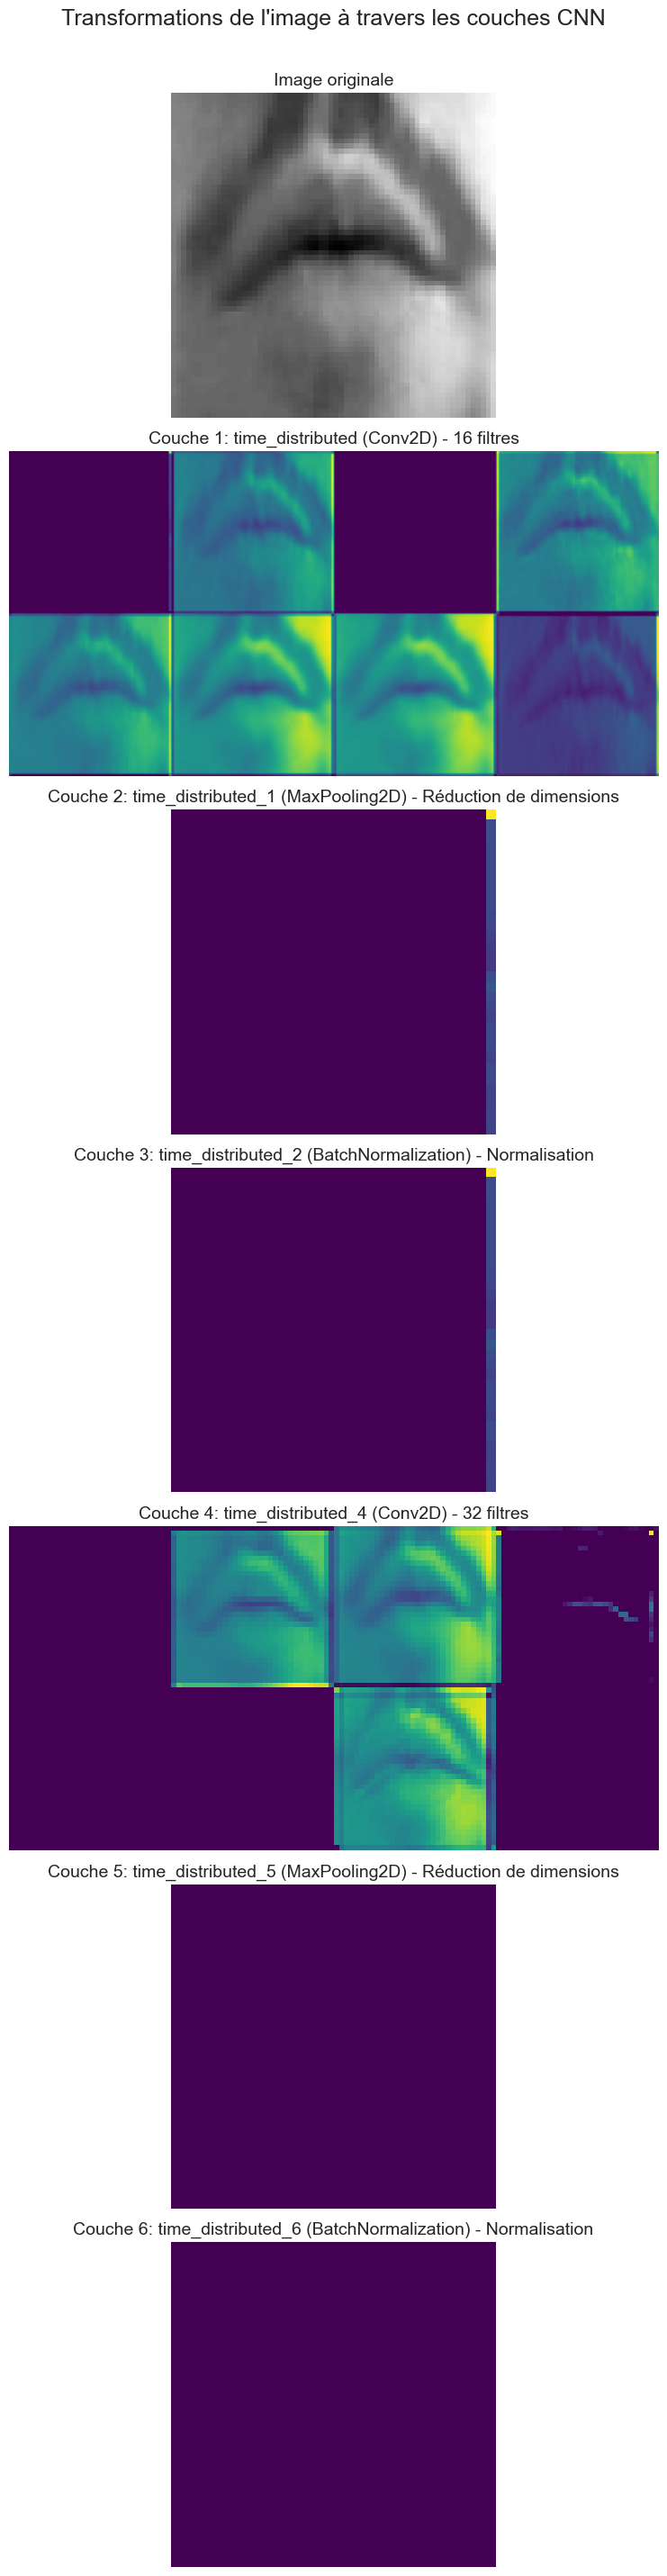

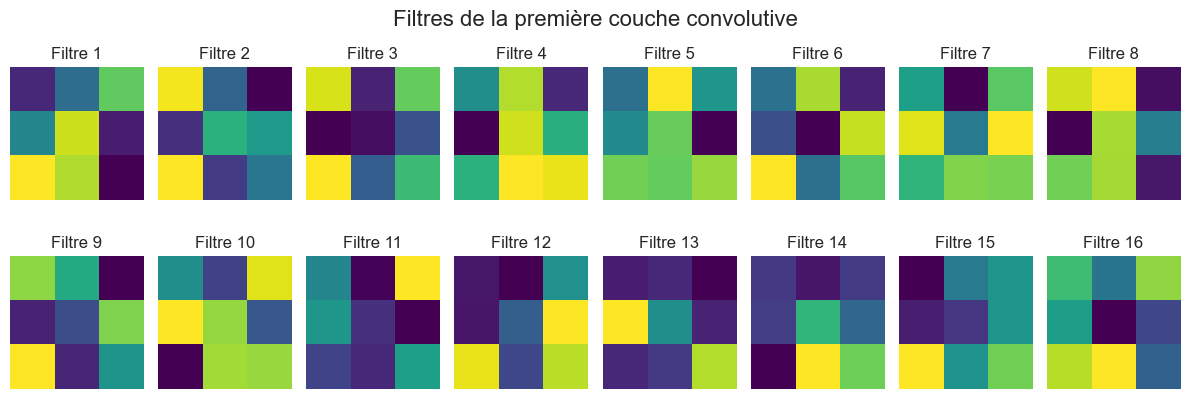

In [15]:
# 1. Sélectionner un exemple
sample_idx = 0  # Premier exemple
X_sample = X_train[sample_idx:sample_idx+1]

# 2. Visualiser le traitement
visualize_neural_processing(model, X_sample)

 ## Entraînement du modèle

In [16]:
# Augmenter les données d'entraînement
X_train_aug, y_train_aug = apply_augmentation(X_train)

Application de l'augmentation de données...
Données augmentées : 192 séquences (× 6.0)


In [17]:
print(len(X_train_aug))


192


In [18]:
import datetime

In [19]:
# Modifier les callbacks pour le modèle CNN+LSTM
checkpoint = ModelCheckpoint(
    os.path.join(models_dir, 'vsr_cnn_lstm_best.h5'), 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=30, 
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  
    patience=10, 
    min_lr=1e-6, 
    verbose=1
)

# Ajouter un TensorBoard callback pour mieux visualiser l'entraînement (optionnel)
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join(models_dir, 'logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
    histogram_freq=1,
    write_graph=True
)

callbacks = [checkpoint, early_stopping, reduce_lr]  

In [20]:
# Paramètres ajustés pour petit dataset
batch_size = 8  # Très petit batch size
epochs = 100    # (avec early stopping)


In [21]:
import matplotlib.pyplot as plt

# Entraînement du modèle
print("Entraînement du modèle CNN+LSTM en cours...")
history = model.fit(
    X_train_aug, y_train_aug,  
    validation_data=(X_test, y_test),  
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

Entraînement du modèle CNN+LSTM en cours...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.2316 - loss: 1.9980
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to ../models\vsr_cnn_lstm_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - accuracy: 0.2321 - loss: 1.9983 - val_accuracy: 0.2500 - val_loss: 1.9306 - learning_rate: 5.0000e-04
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.3434 - loss: 1.9115
Epoch 2: val_accuracy improved from 0.25000 to 0.62500, saving model to ../models\vsr_cnn_lstm_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.3421 - loss: 1.9116 - val_accuracy: 0.6250 - val_loss: 1.8966 - learning_rate: 5.0000e-04
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.3110 - loss: 1.8974
Epoch 3: val_accuracy did not improve from 0.62500
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.3104 - loss: 1.8975 - val_accuracy: 0.5000 - val_loss: 1.8412 - learning_rate: 5.0000e-04
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.3702 - loss: 1.8556
Epoch 4: val_accuracy did not improve from 0.62500
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.3699 - loss: 1.8552 - val_accuracy: 0.5000 - val_loss: 1.7742 - learning_rate: 5.0000e-04
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3478 - loss: 1.8128
Epoch 5: val_accuracy did not improve from 0.62500
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.3472 - loss: 1.8121 - val_accuracy: 0.5000 - val_loss: 1.6727 - learning_rate: 5.0000e-04
Epoch 

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.3373 - loss: 1.7265 - val_accuracy: 0.7500 - val_loss: 1.5221 - learning_rate: 5.0000e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.4287 - loss: 1.6551
Epoch 8: val_accuracy did not improve from 0.75000
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.4282 - loss: 1.6553 - val_accuracy: 0.6250 - val_loss: 1.5143 - learning_rate: 5.0000e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4803 - loss: 1.5998
Epoch 9: val_accuracy did not improve from 0.75000
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.4794 - loss: 1.6005 - val_accuracy: 0.5000 - val_loss: 1.4108 - learning_rate: 5.0000e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.4360 - loss: 1.6051
Epoch 10: val_accuracy did not improve from 0.75000
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.4377 - loss: 1.6035 - val_accuracy: 0.5000 - val_loss: 1.3530 - learning_rate: 5.0000e-04
Epoc

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.5432 - loss: 1.4728 - val_accuracy: 0.8750 - val_loss: 1.2436 - learning_rate: 5.0000e-04
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.5607 - loss: 1.4221
Epoch 12: val_accuracy did not improve from 0.87500
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.5608 - loss: 1.4223 - val_accuracy: 0.8750 - val_loss: 1.1444 - learning_rate: 5.0000e-04
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5231 - loss: 1.3686
Epoch 13: val_accuracy did not improve from 0.87500
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.5237 - loss: 1.3680 - val_accuracy: 0.8750 - val_loss: 1.0640 - learning_rate: 5.0000e-04
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6375 - loss: 1.2948
Epoch 14: val_accuracy improved from 0.87500 to 1.00000, saving model to ../models\vsr_cnn_lstm_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.6364 - loss: 1.2956 - val_accuracy: 1.0000 - val_loss: 0.9338 - learning_rate: 5.0000e-04
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7267 - loss: 1.1837
Epoch 15: val_accuracy did not improve from 1.00000
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.7251 - loss: 1.1845 - val_accuracy: 0.7500 - val_loss: 0.8801 - learning_rate: 5.0000e-04
Epoch 16/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6649 - loss: 1.2226
Epoch 16: val_accuracy did not improve from 1.00000
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.6650 - loss: 1.2209 - val_accuracy: 0.8750 - val_loss: 0.8352 - learning_rate: 5.0000e-04
Epoch 17/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6319 - loss: 1.1673
Epoch 17: val_accuracy did not improve from 1.00000
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.6329 - loss: 1.1670 - val_accuracy: 0.7500 - val_loss: 1.0020 - learning_rate: 5.0000e-04


## Visualisation de l'entraînement

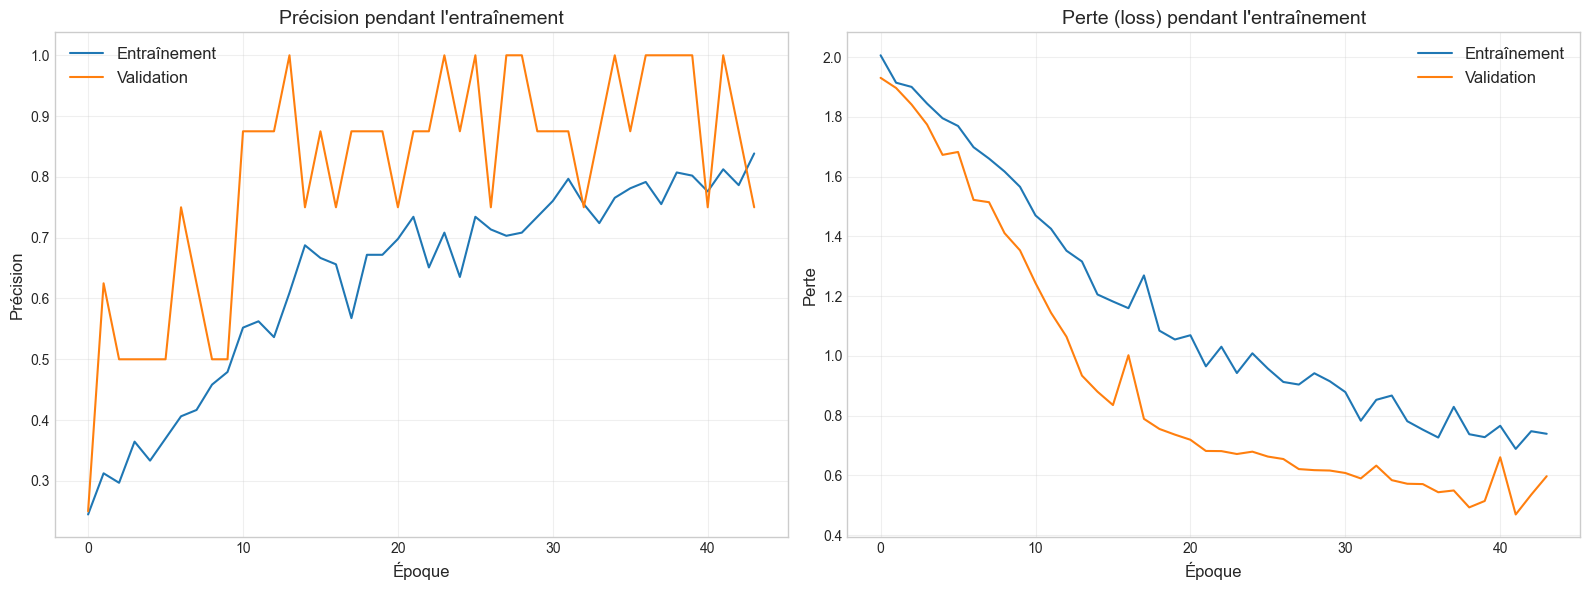

Meilleure précision de validation: 1.0000
Perte minimale de validation: 0.4690


In [25]:
# Fonction pour afficher les courbes d'apprentissage
def plot_learning_curves(history):
    # Configurer la figure
    plt.figure(figsize=(16, 6))
    
    # Courbe de précision
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entraînement')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Précision pendant l\'entraînement', fontsize=14)
    plt.xlabel('Époque', fontsize=12)
    plt.ylabel('Précision', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Courbe de perte
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entraînement')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Perte (loss) pendant l\'entraînement', fontsize=14)
    plt.xlabel('Époque', fontsize=12)
    plt.ylabel('Perte', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Optionnel: Afficher les métriques finales
    print(f"Meilleure précision de validation: {max(history.history['val_accuracy']):.4f}")
    print(f"Perte minimale de validation: {min(history.history['val_loss']):.4f}")
    
    # Optionnel: Courbe du taux d'apprentissage si vous utilisez ReduceLROnPlateau
    if 'lr' in history.history:
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['lr'])
        plt.title('Évolution du taux d\'apprentissage', fontsize=14)
        plt.xlabel('Époque', fontsize=12)
        plt.ylabel('Taux d\'apprentissage', fontsize=12)
        plt.yscale('log')  # Échelle logarithmique pour mieux visualiser
        plt.grid(True, alpha=0.3)
        plt.show()

# Appeler la fonction après l'entraînement
plot_learning_curves(history)

## Évaluation du modèle

Évaluation du modèle sur l'ensemble de test...
Précision sur le test : 1.0000
Perte sur le test : 0.9338
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Rapport de classification :
              precision    recall  f1-score   support

         oui       1.00      1.00      1.00         2
         non       1.00      1.00      1.00         2
          un       1.00      1.00      1.00         2
        deux       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



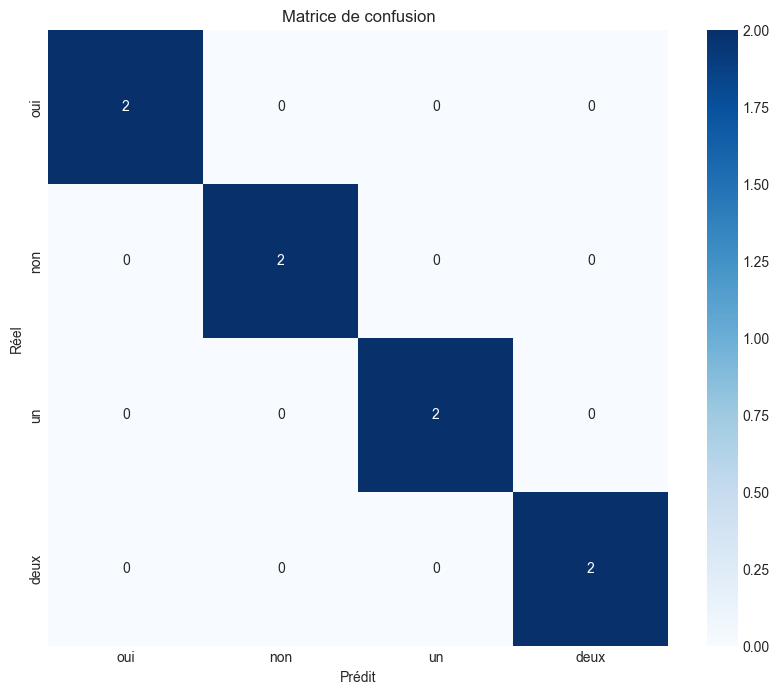

In [23]:
# Évaluer sur l'ensemble de test
print("Évaluation du modèle sur l'ensemble de test...")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Précision sur le test : {test_acc:.4f}")
print(f"Perte sur le test : {test_loss:.4f}")

# Faire des prédictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Rapport de classification
print("\nRapport de classification :")
print(classification_report(y_true, y_pred, target_names=target_words))

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_words, yticklabels=target_words)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()



 ## Sauvegarde du modèle

In [24]:
# Sauvegarder le modèle
model_path = os.path.join(models_dir, 'vsr_cnn_lstm_best.h5')
model.save(model_path)

# Sauvegarder les métadonnées du modèle
model_metadata = {
    'target_words': target_words,
    'img_size': img_size,
    'max_sequence_length': max_sequence_length
}

metadata_path = os.path.join(models_dir, 'vsr_model_metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(model_metadata, f)

print(f"Modèle sauvegardé dans {model_path}")
print(f"Métadonnées sauvegardées dans {metadata_path}")

Modèle sauvegardé dans ../models\vsr_cnn_lstm_best.h5
Métadonnées sauvegardées dans ../models\vsr_model_metadata.pkl
